# Task 3: Customer Segmentation / Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

C:\Users\chott\AppData\Local\Temp\ipykernel_6408\1075886533.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
customer = pd.read_csv("Customers.csv")
product = pd.read_csv("Products.csv")
transaction = pd.read_csv("Transactions.csv")

In [4]:
customer_columns = customer.columns.tolist()
product_columns = product.columns.tolist()
transaction_columns = transaction.columns.tolist()

print("Customer Columns:", customer_columns)
print("Product Columns:", product_columns)
print("Transaction Columns:", transaction_columns)

Customer Columns: ['CustomerID', 'CustomerName', 'Region', 'SignupDate']
Product Columns: ['ProductID', 'ProductName', 'Category', 'Price']
Transaction Columns: ['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price']


In [5]:
# Merge transaction and product dataframes to get category information in transactions
transaction_product = pd.merge(transaction, product, on='ProductID')

# Create a pivot table to count the number of purchases per category for each customer
category_pivot = transaction_product.pivot_table(index='CustomerID', columns='Category', values='Quantity', aggfunc='sum', fill_value=0)

# Calculate total spending by each customer
total_spending = transaction.groupby('CustomerID')['TotalValue'].sum()

# Merge the customer dataframe with the category pivot table and total spending
look_alike = pd.merge(customer, category_pivot, on='CustomerID', how='left')
look_alike = pd.merge(look_alike, total_spending, on='CustomerID', how='left')

# Rename the 'TotalValue' column to 'TotalSpending'
look_alike.rename(columns={'TotalValue': 'TotalSpending'}, inplace=True)

In [6]:
look_alike.head()

,CustomerID,CustomerName,Region,SignupDate,Books,Clothing,Electronics,Home Decor,TotalSpending
0,C0001,Lawrence Carroll,South America,2022-07-10,2.0,0.0,7.0,3.0,3354.52
1,C0002,Elizabeth Lutz,Asia,2022-02-13,0.0,4.0,0.0,6.0,1862.74
2,C0003,Michael Rivera,South America,2024-03-07,0.0,4.0,4.0,6.0,2725.38
3,C0004,Kathleen Rodriguez,South America,2022-10-09,8.0,0.0,6.0,9.0,5354.88
4,C0005,Laura Weber,Asia,2022-08-15,0.0,0.0,4.0,3.0,2034.24


In [10]:
!pip install kmodes

Davies-Bouldin Index: 1.388575271565659


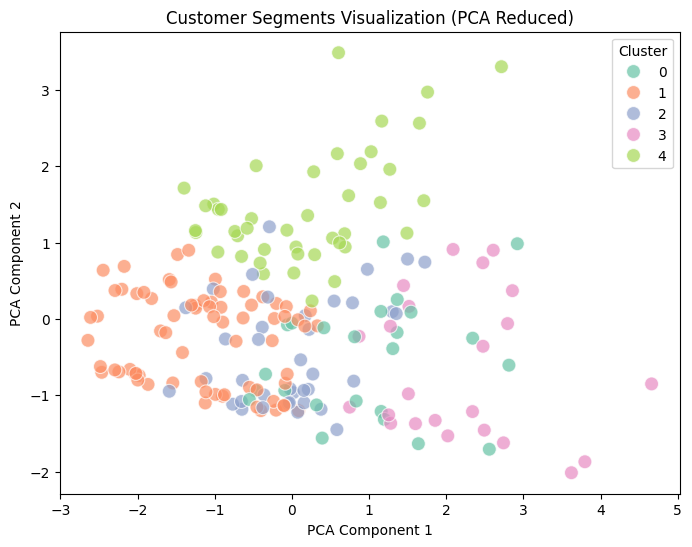

  Cluster     Books            Clothing           Electronics            \
               mean       std      mean       std        mean       std   
0       0  2.708333  2.561914  2.333333  2.057154    8.708333  2.216130   
1       1  3.014085  2.875974  0.957746  1.235622    1.605634  1.808542   
2       2  2.263158  1.912748  6.289474  2.228900    2.315789  1.817412   
3       3  8.304348  2.438979  5.913043  4.166021    4.826087  2.757670   
4       4  2.906977  2.358510  2.116279  1.990565    2.441860  2.260450   

  Home Decor           TotalSpending                      Region  
        mean       std          mean          std       <lambda>  
0   2.208333  2.245366   4625.723333  1438.108254  North America  
1   1.901408  1.640165   1976.148592  1080.700527  South America  
2   2.000000  2.143501   3330.802368  1197.833922           Asia  
3   2.478261  2.826330   6048.081304  1368.387644  South America  
4   7.395349  2.401780   4023.146279  1415.554298  South America  


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Load data from CSV
data = look_alike

# Clean the data by removing rows with missing values
data_clean = data.dropna(subset=['Books', 'Clothing', 'Electronics', 'Home Decor', 'TotalSpending', 'Region'])

# Extract numeric features for clustering
numeric_features = ['Books', 'Clothing', 'Electronics', 'Home Decor', 'TotalSpending']
X = data_clean[numeric_features]

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
k = 5  # Number of clusters
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
data_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, data_clean['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

# Visualize the clusters
# 2D visualization using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_clean['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title('Customer Segments Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Display statistics of each cluster
cluster_stats = data_clean.groupby('Cluster').agg({
    'Books': ['mean', 'std'],
    'Clothing': ['mean', 'std'],
    'Electronics': ['mean', 'std'],
    'Home Decor': ['mean', 'std'],
    'TotalSpending': ['mean', 'std'],
    'Region': lambda x: x.value_counts().idxmax()  # Most common region in each cluster
}).reset_index()

print(cluster_stats)

# Save the results to a CSV file if you want
data_clean.to_csv('segmented_customers.csv', index=False)


### DB Score is vary high we will try to reduce it

In [16]:
from sklearn.cluster import DBSCAN

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
data_clean['Cluster'] = dbscan.fit_predict(X_scaled)

# Calculate DB Index for DBSCAN
db_index_dbscan = davies_bouldin_score(X_scaled, data_clean['Cluster'])
print(f'Davies-Bouldin Index for DBSCAN: {db_index_dbscan}')


Davies-Bouldin Index for DBSCAN: 0.9537175721426561


### Even with the DBSCAN RESULTS THE NOT VERY GOOD


In [19]:
from sklearn.decomposition import PCA

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans to the reduced data
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
data_clean['Cluster'] = kmeans.fit_predict(X_pca)

# Calculate DB Index for reduced dimensions
db_index_pca = davies_bouldin_score(X_pca, data_clean['Cluster'])
print(f'Davies-Bouldin Index after PCA: {db_index_pca}')


Davies-Bouldin Index after PCA: 0.8365783713518734


Optimal number of clusters (k): 9
Davies-Bouldin Index after PCA: 0.7553801727172699


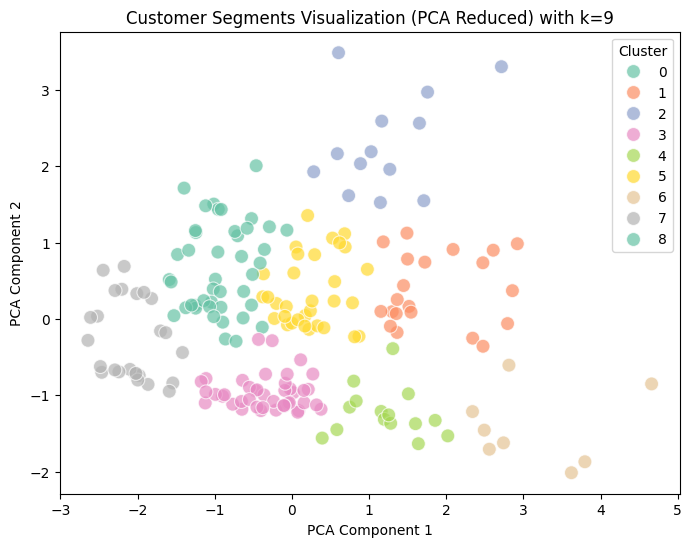

  Cluster     Books            Clothing           Electronics            \
               mean       std      mean       std        mean       std   
0       0  2.000000  1.834022  1.782609  2.131080    1.695652  1.987113   
1       1  4.666667  3.022141  5.904762  3.534187    5.380952  2.923631   
2       2  4.153846  2.882307  1.923077  2.059998    3.615385  2.724532   
3       3  3.785714  2.727777  3.214286  2.798394    3.119048  2.401243   
4       4  6.266667  3.918211  3.800000  3.363671    6.000000  3.835920   
5       5  3.625000  2.459347  2.843750  2.201310    3.250000  2.711981   
6       6  8.500000  1.851640  7.125000  5.111262    8.000000  3.116775   
7       7  0.680000  1.180395  0.880000  1.452584    0.640000  1.113553   
8       8  1.450000  1.731291  1.900000  2.381950    1.150000  1.631112   

  Home Decor           TotalSpending                      Region  
        mean       std          mean          std       <lambda>  
0   3.217391  0.599736   2231.693043   6

In [24]:

data = look_alike

# Clean the data by removing rows with missing values
data_clean = data.dropna(subset=['Books', 'Clothing', 'Electronics', 'Home Decor', 'TotalSpending', 'Region'])

# Extract numeric features for clustering
numeric_features = ['Books', 'Clothing', 'Electronics', 'Home Decor', 'TotalSpending']
X = data_clean[numeric_features]

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to calculate DB Index for different k values
def calculate_db_index(X_data, max_k=10):
    db_indices = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_data)
        db_index = davies_bouldin_score(X_data, clusters)
        db_indices.append((k, db_index))
    return db_indices

# Find optimal k using DB Index
db_indices = calculate_db_index(X_scaled)
best_k = min(db_indices, key=lambda x: x[1])[0]  # Choosing the k with the lowest DB Index
print(f'Optimal number of clusters (k): {best_k}')

# Apply PCA to reduce the dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans to the reduced data (with the best k)
kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42, n_init=10)
data_clean['Cluster'] = kmeans.fit_predict(X_pca)

# Calculate DB Index after PCA reduction
db_index_pca = davies_bouldin_score(X_pca, data_clean['Cluster'])
print(f'Davies-Bouldin Index after PCA: {db_index_pca}')

# Visualize the clusters in the 2D PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_clean['Cluster'], palette='Set2', s=100, alpha=0.7)
plt.title(f'Customer Segments Visualization (PCA Reduced) with k={best_k}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Display statistics of each cluster
cluster_stats = data_clean.groupby('Cluster').agg({
    'Books': ['mean', 'std'],
    'Clothing': ['mean', 'std'],
    'Electronics': ['mean', 'std'],
    'Home Decor': ['mean', 'std'],
    'TotalSpending': ['mean', 'std'],
    'Region': lambda x: x.value_counts().idxmax()  # Most common region in each cluster
}).reset_index()

print(cluster_stats)

# Save the results to a CSV file if you want
data_clean.to_csv('segmented_customers_with_pca.csv', index=False)


### this one seems way batter with the 9 clusters asn good DB Score